# Data Exploration using pyspark and pandas

* We are going to explore the movies_metadata.csv file from the TMDB dataset. 
* We will primarily utilise pyspark and pandas for this
* For plotting we'll use seaborn and matplotlib

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

sns.set_style('darkgrid')
sns.set_context('talk')

In [3]:
# Starting a spark session locally
spark = SparkSession \
    .builder \
    .appName("movie-rec-explore") \
    .getOrCreate()

Let's load up the metadata for the movies and explore its contents.

In [4]:
movie_met = spark.read.csv('data/movies_metadata.csv', header=True)
movie_met.printSchema()

root
 |-- adult: string (nullable = true)
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: string (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- video: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- vote_count: string (nu

In [5]:
# We see plenty of columns that we do not require in out analysis. We'll drop them
# Also notice that the dtype is string for all columns
# This might imply that they contain a mix of different dytpes

# Dropping the columns not needed
movie_met = movie_met.drop(*['homepage', 'imdb_id', 'original_title', 'poster_path', 'video', 'belongs_to_collection', 'revenue', 'tagline', 'overview', 'spoken_languages', 'production_countries'])

In [6]:
movie_met.toPandas().describe(include='all')

,adult,budget,genres,id,original_language,popularity,production_companies,release_date,runtime,status,title,vote_average,vote_count
count,45572,45555,45549,45541,45527,45452,45448,45378,45168,45327,44794,45074,45183
unique,111,1358,4172,45469,246,43911,24644,19065,2535,1367,40102,1573,2898
top,False,0,"[{'id': 18, 'name': 'Drama'}]","[{'id': 35, 'name': 'Comedy'}]",en,0.0,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",90.0,Released,Released,0.0,1
freq,45454,36509,4996,15,32185,67,10871,478,2334,41194,749,2756,2972


In [7]:
def count_nans(df):
    return df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas()
    
def count_nulls(df):
    return df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

In [8]:
count_nulls(movie_met)

,adult,budget,genres,id,original_language,popularity,production_companies,release_date,runtime,status,title,vote_average,vote_count
0,0,17,23,31,45,120,124,194,404,245,778,498,389


In [9]:
count_nans(movie_met)

,adult,budget,genres,id,original_language,popularity,production_companies,release_date,runtime,status,title,vote_average,vote_count
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
def to_dtype_remove_null(df, col_name, dtype_out):
    df = df.withColumn(col_name, col(col_name).cast(dtype_out))
    df = df.filter(df[col_name].isNotNull())
    return df

In [11]:
# Cleaning the id, popularity, runtime, vote_average, vote_count columns
# Changing to type int and removing Nan/null rows

movie_met = to_dtype_remove_null(movie_met, 'id', 'int')
movie_met = to_dtype_remove_null(movie_met, 'popularity', 'float')
movie_met = to_dtype_remove_null(movie_met, 'runtime', 'int')
movie_met = to_dtype_remove_null(movie_met, 'vote_average', 'float')
movie_met = to_dtype_remove_null(movie_met, 'vote_count', 'int')
movie_met = to_dtype_remove_null(movie_met, 'budget', 'int')

In [12]:
# Keeping only the release year
# Cleaning NaN/Null rows

movie_met = movie_met.withColumn('year', year(movie_met['release_date'])).drop('release_date')
movie_met = movie_met.filter(movie_met['year'].isNotNull())

In [13]:
count_nulls(movie_met)

,adult,budget,genres,id,original_language,popularity,production_companies,runtime,status,title,vote_average,vote_count,year
0,0,0,0,0,11,0,0,0,66,0,0,0,0


In [14]:
movie_met.filter(movie_met['original_language'].isNull()).toPandas().head()

,adult,budget,genres,id,original_language,popularity,production_companies,runtime,status,title,vote_average,vote_count,year
0,False,0,"[{'id': 99, 'name': 'Documentary'}]",283101,None,0.017007,"[{'name': 'StudioCanal', 'id': 694}, {'name': ...",95,Released,Shadowing the Third Man,0.0,0,2004
1,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",103902,None,0.359818,"[{'name': 'New Holland Pictures', 'id': 10229}...",94,Released,Unfinished Sky,6.4,8,2007
2,False,0,"[{'id': 10752, 'name': 'War'}, {'id': 37, 'nam...",359195,None,0.070647,"[{'name': 'Associated Producers (API)', 'id': ...",69,Released,13 Fighting Men,0.0,0,1960
3,False,0,"[{'id': 35, 'name': 'Comedy'}]",147050,None,0.073418,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",8,Released,Lambchops,6.5,2,1929
4,False,0,"[{'id': 16, 'name': 'Animation'}]",257095,None,0.036841,"[{'name': 'Ceskoslovenský Státní Film', 'id': ...",87,Released,Prince Bayaya,5.0,1,1950


In [15]:
# Seeing how many movies are rated adult or otherwise
movie_met.groupBy('adult').count().orderBy('count', ascending=False).toPandas()

,adult,count
0,False,41234
1,True,8


In [16]:
# Seeing how many movies are released or otherwise
movie_met.groupBy('status').count().orderBy('count', ascending=False).toPandas()

,status,count
0,Released,40850
1,Rumored,205
2,Post Production,93
3,None,66
4,In Production,16
5,Planned,12


In [17]:
# Let's just keep the adult=False rows and drop this column.
# movie_met.filter(movie_met['adult'] == 'False').groupBy('adult').count().orderBy('count', ascending=False).toPandas()
movie_met = movie_met.filter(movie_met['adult'] == 'False').drop('adult')

In [18]:
# Let's just keep the movies that are released.
movie_met = movie_met.filter(movie_met['status'] == 'Released').drop('status')

In [19]:
movie_met.printSchema()

root
 |-- budget: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- original_language: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- year: integer (nullable = true)



In [20]:
movie_met.toPandas().describe(include='all')

,budget,genres,id,original_language,popularity,production_companies,runtime,title,vote_average,vote_count,year
count,4.084200e+04,40842,40842.000000,40832,40842.000000,40842,40842.000000,40842,40842.000000,40842.000000,40842.000000
unique,NaN,3846,NaN,86,NaN,20731,NaN,38141,NaN,NaN,NaN
top,NaN,"[{'id': 18, 'name': 'Drama'}]",NaN,en,NaN,[],NaN,Cinderella,NaN,NaN,NaN
freq,NaN,4517,NaN,29174,NaN,10426,NaN,11,NaN,NaN,NaN
mean,4.322854e+06,NaN,108298.777557,NaN,2.981002,NaN,94.329514,NaN,5.635136,111.652466,1991.928750
std,1.767062e+07,NaN,112391.551247,NaN,6.134999,NaN,38.325357,NaN,1.891718,489.720398,24.171114
min,0.000000e+00,NaN,2.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,1874.000000
25%,0.000000e+00,NaN,26177.250000,NaN,0.404185,NaN,85.000000,NaN,5.000000,3.000000,1978.000000
50%,0.000000e+00,NaN,60016.500000,NaN,1.160836,NaN,95.000000,NaN,6.000000,10.000000,2001.000000
75%,0.000000e+00,NaN,157723.750000,NaN,3.819692,NaN,107.000000,NaN,6.800000,35.000000,2011.000000


In [21]:
# Checking for duplicate ids
movie_met.groupBy('id').count().orderBy('count', ascending=False).toPandas()

,id,count
0,141971,3
1,265189,2
2,109962,2
3,110428,2
4,25541,2
...,...,...
40810,201429,1
40811,131343,1
40812,119984,1
40813,194039,1


In [22]:
movie_met.filter(movie_met['id'] == 141971).toPandas()

,budget,genres,id,original_language,popularity,production_companies,runtime,title,vote_average,vote_count,year
0,0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",141971,fi,0.411949,"[{'name': 'Filmiteollisuus Fine', 'id': 5166}]",108,Blackout,6.7,3,2008
1,0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",141971,fi,0.411949,"[{'name': 'Filmiteollisuus Fine', 'id': 5166}]",108,Blackout,6.7,3,2008
2,0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",141971,fi,0.411949,"[{'name': 'Filmiteollisuus Fine', 'id': 5166}]",108,Blackout,6.7,3,2008


In [23]:
# There are a few duplicate ids and titles
# movie_met.dropDuplicates(['id']).groupBy('id').count().orderBy('count', ascending=False).toPandas()
movie_met = movie_met.dropDuplicates(['id'])

In [24]:
movie_met.groupBy('title').count().orderBy('count', ascending=False).toPandas()

,title,count
0,Cinderella,11
1,Alice in Wonderland,9
2,Beauty and the Beast,8
3,Hamlet,8
4,Les Misérables,7
...,...,...
38136,You Are God,1
38137,Life Stinks,1
38138,Barbie: A Fairy Secret,1
38139,Boca,1


In [25]:
movie_met.filter(movie_met['title'] == 'Cinderella').toPandas().head()

,budget,genres,id,original_language,popularity,production_companies,runtime,title,vote_average,vote_count,year
0,0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 107...",42884,en,2.102013,"[{'name': 'Walt Disney Television', 'id': 670}...",88,Cinderella,6.1,28,1997
1,0,[],289673,en,1.085134,[],90,Cinderella,5.6,5,2000
2,0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",92349,en,0.361288,[],52,Cinderella,5.4,7,1914
3,2900000,"[{'id': 10751, 'name': 'Family'}, {'id': 14, '...",11224,en,14.436858,"[{'name': 'RKO Radio Pictures', 'id': 6}, {'na...",74,Cinderella,6.8,1760,1950
4,95000000,"[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",150689,en,19.801128,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",105,Cinderella,6.7,2426,2015


Appears that the duplicate movies are actually distinct. Let's just keep them

In [26]:
count_nulls(movie_met)

,budget,genres,id,original_language,popularity,production_companies,runtime,title,vote_average,vote_count,year
0,0,0,0,10,0,0,0,0,0,0,0


In [27]:
movie_met = movie_met.fillna("unknown", subset=["original_language"])

In [28]:
movie_met.createOrReplaceTempView('movie_met')

In [29]:
query = """
        SELECT original_language AS lang, COUNT(1) AS num_movies
        FROM movie_met
        GROUP BY lang
        ORDER BY num_movies DESC
        """

spark.sql(query).toPandas()

,lang,num_movies
0,en,29158
1,fr,2140
2,it,1328
3,ja,1211
4,de,932
...,...,...
82,zu,1
83,eo,1
84,sm,1
85,la,1


In [30]:
df_mmd = movie_met.toPandas()
df_mmd.head()

,budget,genres,id,original_language,popularity,production_companies,runtime,title,vote_average,vote_count,year
0,5000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",148,en,12.775583,"[{'name': 'Hotshot Films', 'id': 78}]",112,The Secret Life of Words,6.8,52,2005
1,0,"[{'id': 18, 'name': 'Drama'}]",471,en,0.707491,"[{'name': 'Douek Productions', 'id': 259}]",102,Bandyta,6.3,3,1997
2,18000000,"[{'id': 35, 'name': 'Comedy'}]",496,en,8.278336,[{'name': 'Twentieth Century Fox Film Corporat...,82,Borat: Cultural Learnings of America for Make ...,6.5,1617,2006
3,0,"[{'id': 18, 'name': 'Drama'}]",833,it,5.710230,"[{'name': 'Rizzoli Film', 'id': 12778}, {'name...",89,Umberto D.,8.0,92,1952
4,8000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",1088,en,11.040186,"[{'name': 'South Pacific Pictures', 'id': 654}]",101,Whale Rider,7.1,114,2003


In [31]:
# Extract genres
df_mmd.genres = df_mmd.genres.map(lambda col_str: [col_dict['name'] for col_dict in eval(col_str)])

[Text(0, 0, 'Drama'),
 Text(0, 0, 'Comedy'),
 Text(0, 0, 'Thriller'),
 Text(0, 0, 'Romance'),
 Text(0, 0, 'Action'),
 Text(0, 0, 'Horror'),
 Text(0, 0, 'Crime'),
 Text(0, 0, 'Documentary'),
 Text(0, 0, 'Adventure'),
 Text(0, 0, 'Science Fiction'),
 Text(0, 0, 'Family'),
 Text(0, 0, 'Mystery'),
 Text(0, 0, 'Fantasy'),
 Text(0, 0, 'Animation'),
 Text(0, 0, 'Foreign'),
 Text(0, 0, 'Music'),
 Text(0, 0, 'History'),
 Text(0, 0, 'War'),
 Text(0, 0, 'Western'),
 Text(0, 0, 'TV Movie')]

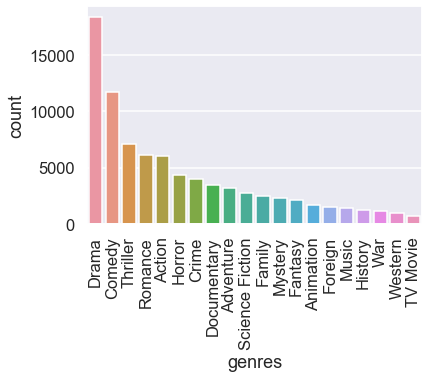

In [32]:
g = sns.countplot(x="genres", data=df_mmd.explode('genres'), order=df_mmd.explode('genres')['genres'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [33]:
# Extract production companies
df_mmd.at[9164, 'production_companies'] = "[]"
df_mmd.production_companies = df_mmd.production_companies.map(lambda col_str: [col_dict['name'] for col_dict in eval(col_str)])
# df_mmd.production_companies.map(lambda col_str: [col_dict['name'] for col_dict in eval(col_str)])

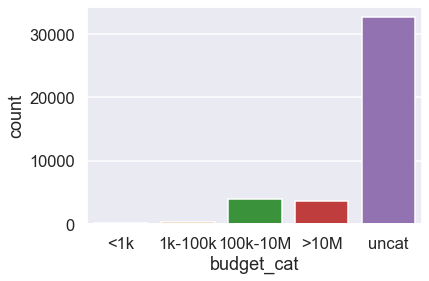

In [34]:
# Categories the budgets into bins
df_budget = movie_met.select('budget').toPandas()
df_budget['budget_cat'] = pd.cut(df_budget.budget, bins=[0,1000,100000,10000000,1000000000], labels=["<1k", "1k-100k", "100k-10M", ">10M"])
df_budget.budget_cat = df_budget.budget_cat.cat.add_categories('uncat')
df_budget.budget_cat.fillna('uncat', inplace=True)
sns.countplot(x="budget_cat", data=df_budget)

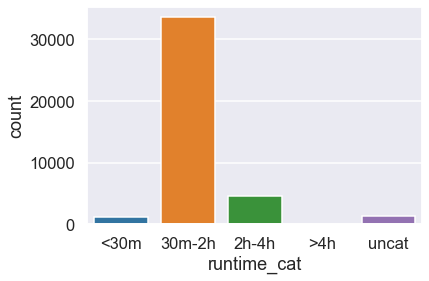

In [35]:
# Categorising run times
df_mmd['runtime_cat'] = pd.cut(df_mmd.runtime, bins=[0,30,120,480,1256], labels=["<30m", "30m-2h", "2h-4h", ">4h"], right=True)
df_mmd.runtime_cat = df_mmd.runtime_cat.cat.add_categories('uncat')
df_mmd.runtime_cat.fillna('uncat', inplace=True)
sns.countplot(x="runtime_cat", data=df_mmd)

In [36]:
df_mmd.isnull().sum()

budget                  0
genres                  0
id                      0
original_language       0
popularity              0
production_companies    0
runtime                 0
title                   0
vote_average            0
vote_count              0
year                    0
runtime_cat             0
dtype: int64

In [38]:
num_valid_pc = len(df_mmd[df_mmd.production_companies.map(len) > 0])
num_valid_gen = len(df_mmd[df_mmd.genres.map(len) > 0])
num_unique_pc = len(df_mmd.explode('production_companies')['production_companies'].unique())

print(f"Number of valid rown with production companies: {num_valid_pc}")
print(f"Number of valid rown with genres: {num_valid_gen}")
print(f"Number of unique production companies: {num_unique_pc}")

Number of valid rown with production companies: 30394
Number of valid rown with genres: 38758
Number of unique production companies: 21777


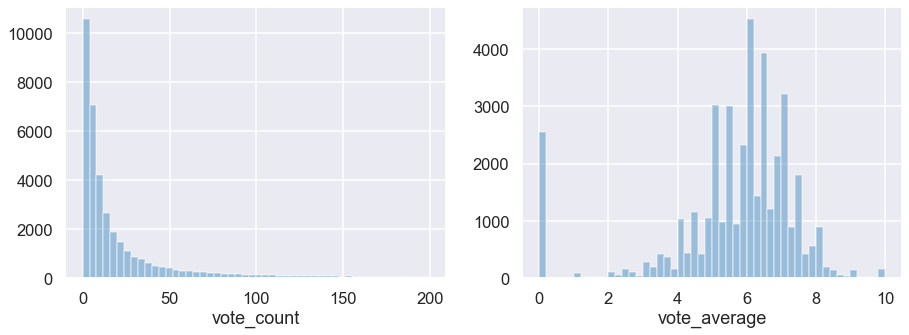

In [39]:
f, axes = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(df_mmd[df_mmd.vote_count<200].vote_count, ax=axes[0], kde=False)
sns.distplot(df_mmd.vote_average, ax=axes[1], kde=False)